Захаров Вадим

In [48]:
import gym
import math
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

# Часть первая: крестики-нолики при помощи Q-обучения

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=3, n_cols=3, n_win=3):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def random_choice(x):
    idx = np.random.randint(0, len(x))
    return x[idx]

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
def get_size(mw,mh,kw,kh):
    return mw-kw+1, mh-kh+1

class DQNetwork(nn.Module):
    def __init__(self, H, W, channels=256, kernel_size=3):
        
        fw,fh = get_size(W, H, kernel_size, kernel_size)
        super(DQNetwork, self).__init__()
        self.conv = nn.Conv2d(1, channels, kernel_size=kernel_size)
        self.fc = nn.Linear(channels * fh * fw, H * W)

    def forward(self, x):
        x = F.relu(self.conv(x))
        return self.fc(x.view(x.size(0), -1))

In [5]:
class Qlearning:
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1, N_ROWS=3,N_COLS=3,N_WIN=3):
        
        self.Q = {}
        self.Q_zeros = None
        
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        self.env = TicTacToe(N_ROWS,N_COLS,N_WIN)
        self.all_train_iters = 0
        self.action_space = list(range(N_ROWS*N_COLS))
        
    def get_rewards(self, state, zeros=False):
        
        if zeros:
            Q = self.Q_zeros
        else:
            Q = self.Q
        if state not in Q:
            R = -10 * np.ones(len(self.action_space))
            for i in range(len(R)):
                cell = self.env.action_from_int(i)
                if self.env.board[cell[0], cell[1]] == 0:
                    R[i] = 0
                    
            Q[state] = R
        return Q[state]
    
    def get_next_action(self, state, zeros=False):
        rewards = self.get_rewards(state, zeros)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state, zeros=False):
        if np.random.rand() < self.eps:
            action = random_choice(self.env.getEmptySpaces())
            action = self.env.int_from_action(action)
        else:
            action = self.get_next_action(state,zeros)
        return action
            
    def run_episode(self):
        
        self.env.reset()
        state = self.env.getHash()
        
        done = False
        steps = []
        
        while not done:
            if self.env.curTurn == 1:
                
                action = self.epsilon_greedy_policy(state)
                steps.append((state, action))
                action = self.env.action_from_int(action)
                
            else:
                if self.Q_zeros is None:
                    action = random_choice(self.env.getEmptySpaces())
                    
                else:
                    state_for_zeros = state.replace('2','3').replace('0','2').replace('3','0')
                    action = self.epsilon_greedy_policy(state_for_zeros, zeros=True)
                    action = self.env.action_from_int(action)
                    
            state, reward, done, _ = self.env.step(action)
            state = state[0]
        return steps, reward
    
    def train(self, n_iters=200000, merger_period=5000):
        for n in range(n_iters):
            if (self.all_train_iters + 1) % merger_period == 0:
                self.Q_zeros = self.Q.copy()
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
                
            self.all_train_iters += 1
    
    def inference(self, n_iters=100000):
        avg_V = 0
        for i in range(1, n_iters+1):
            self.env.reset()
            state = self.env.getHash()
            done = False
            while not done:
                if self.env.curTurn == 1:
                    action = self.get_next_action(state)
                    action = self.env.action_from_int(action)
                else:
                    action = random_choice(self.env.getEmptySpaces())
                state, G, done, _ = self.env.step(action)
                state = state[0]
            avg_V += (G - avg_V) / i
        return avg_V

## Для доски 3x3

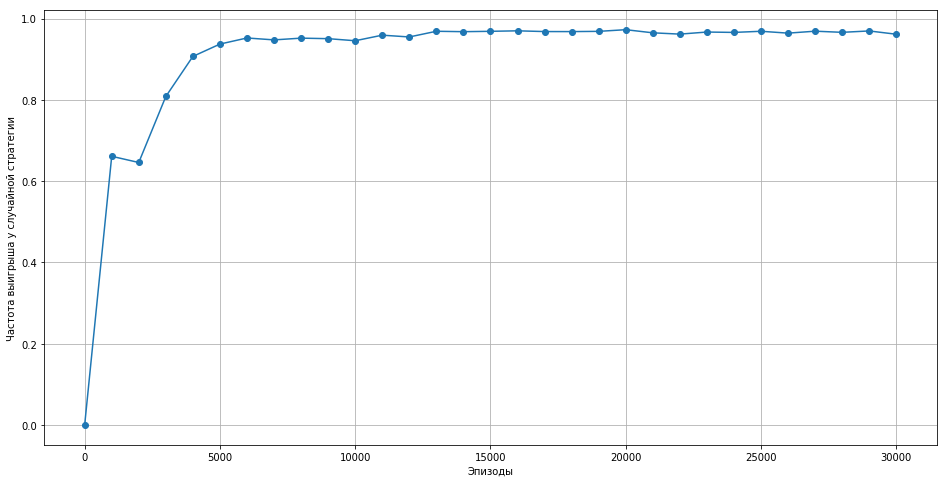

In [5]:
QL = Qlearning(gamma=0.95, alpha=0.0001, eps=0.1)
delta_inf = 1000
n_iters = 30000
G = [0]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    QL.train(delta_inf, merger_period=n_iters)
    gain = QL.inference(10000)
    G.append(gain)
    episode.append(i*delta_inf)
    
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Частота выигрыша у случайной стратегии')
plt.grid()
plt.show()

## Для доски 4x4

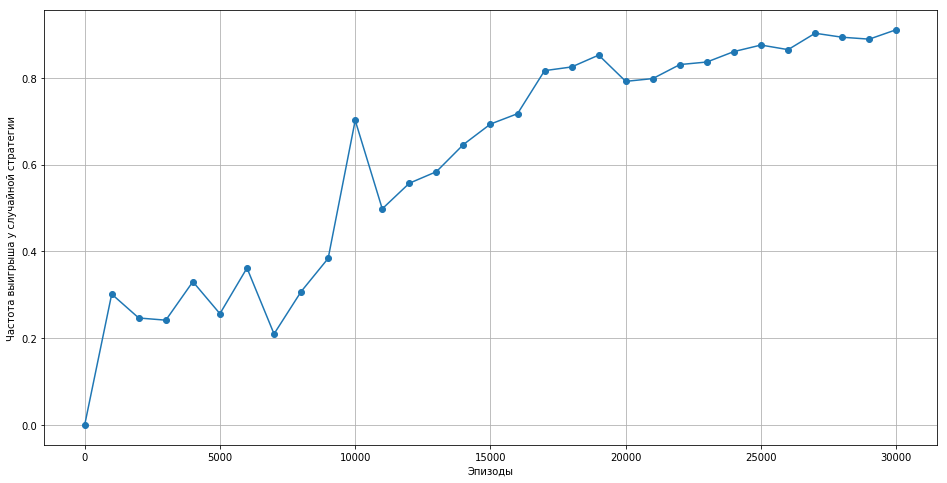

In [6]:
QL = Qlearning(gamma=0.95, alpha=0.0001, eps=0.1, N_ROWS=4, N_COLS=4, N_WIN=3)
delta_inf = 1000
n_iters = 30000
G = [0]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    QL.train(delta_inf, merger_period=n_iters)
    gain = QL.inference(10000)
    G.append(gain)
    episode.append(i*delta_inf)
    
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Частота выигрыша у случайной стратегии')
plt.grid()
plt.show()

## Для доски 5x5

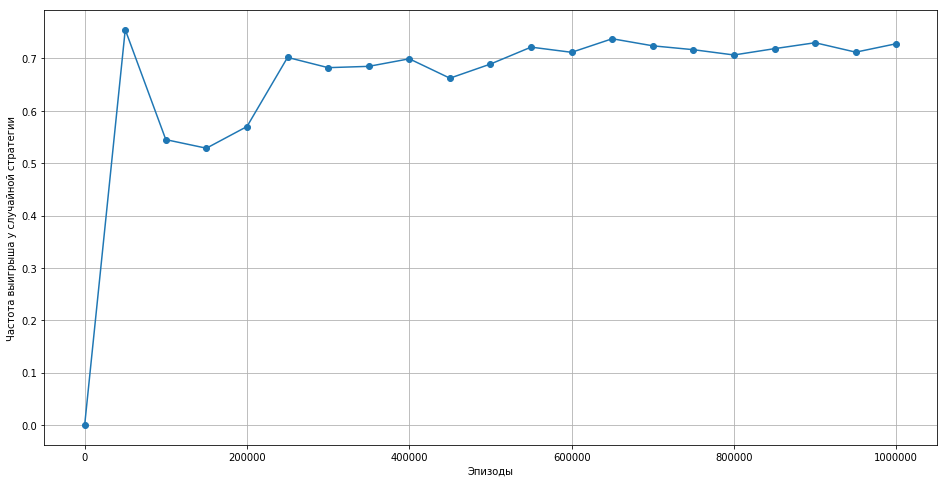

In [213]:
QL = Qlearning(gamma=0.8, alpha=0.001, eps=0.1, N_ROWS=5, N_COLS=5, N_WIN=4)
delta_inf = 50000
n_iters = 1000000
G = [0]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    QL.train(delta_inf, merger_period=n_iters)
    gain = QL.inference(10000)
    G.append(gain)
    episode.append(i*delta_inf)
    
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Частота выигрыша у случайной стратегии')
plt.grid()
plt.show()

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

4. Реализуйте Double DQN и/или Dueling DQN.

### DQN

In [10]:
class TTTDQN():
    def __init__(self, gamma=0.95, N_ROWS=3, N_COLS=3, N_WIN=3, batch_size=64):
        
        self.env = TicTacToe(N_ROWS,N_COLS,N_WIN)
        self.model = DQNetwork(N_ROWS, N_COLS)
        self.memory = ReplayMemory(30*batch_size)
        
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        
        self.N_ROWS = N_ROWS
        self.N_COLS = N_COLS
        
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0

    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            action = random_choice(self.env.getEmptySpaces())
            action = self.env.int_from_action(action)
            return torch.tensor([[action]], dtype=torch.int64)

    
    
    def run_episode(self, do_learning=True, greedy=False):
        self.env.reset()
        state = self.env.board.reshape(1, self.N_ROWS, self.N_COLS)
        done = False
        
        while not done:
            
            if self.env.curTurn == 1:
                state_tensor = torch.tensor([state], dtype=torch.float32)
                with torch.no_grad():
                    if greedy:
                        action = self.select_greedy_action(state_tensor)
                    else:
                        action = self.select_action(state_tensor)
                
                _, reward, done, _ = self.env.step(self.env.action_from_int(action.numpy()[0][0]))
                next_state = self.env.board.reshape(1, self.N_ROWS, self.N_COLS)
                next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

                
                if do_learning:
                    transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                    self.memory.store(transition)
                    self.learn()

            else:
                action = random_choice(self.env.getEmptySpaces())
                _, reward, done, _ = self.env.step(action)
                next_state = self.env.board.reshape(1, self.N_ROWS, self.N_COLS)
                

            state = next_state
            
        return reward


    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
    def run(self,n_iters=10000, do_learning=True, greedy=False):
        avg_V = 0
        for i in range(1, n_iters+1):
            G = self.run_episode(do_learning=do_learning, greedy=greedy)
            avg_V += (G - avg_V) / i
        return avg_V

## Для доски 3x3

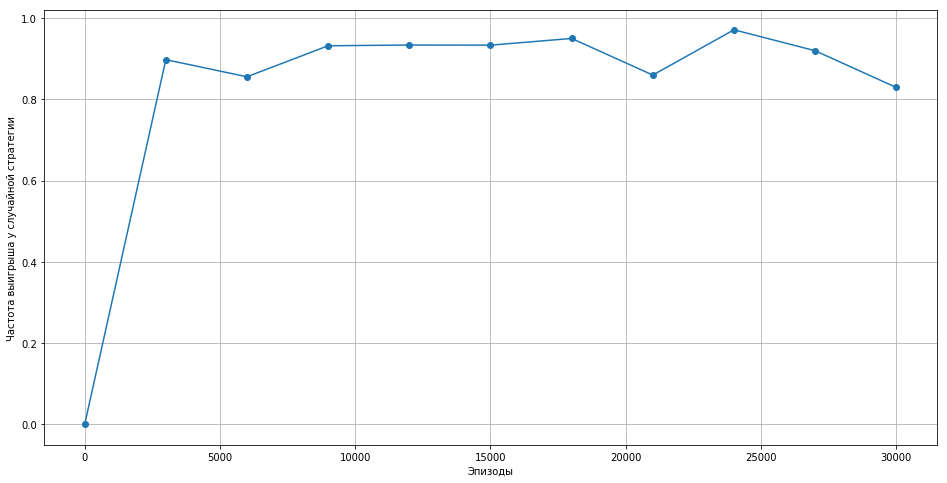

CPU times: user 33min 39s, sys: 54.8 s, total: 34min 34s
Wall time: 6min 25s


In [187]:
%%time
DQN = TTTDQN(gamma=0.7, batch_size=128)
n_iters = 30000
delta_inf = 3000
G = [0]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    DQN.run(delta_inf, do_learning=True, greedy=False)
    gain = DQN.run(10000, do_learning=False, greedy=True)
    G.append(gain)
    episode.append(i*delta_inf)
    
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Частота выигрыша у случайной стратегии')
plt.grid()
plt.ylim([-0.05,1.02])
plt.show()

## Для доски 4x4

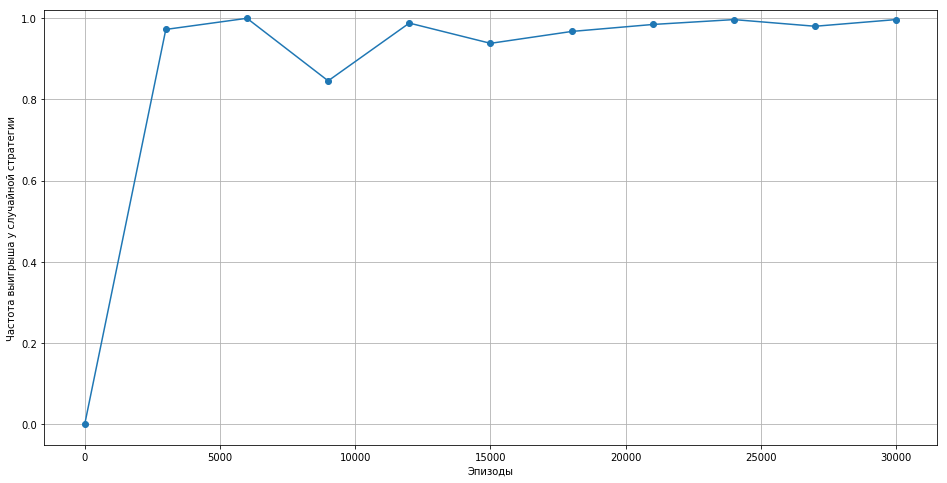

CPU times: user 46min 11s, sys: 1min 51s, total: 48min 2s
Wall time: 9min 19s


In [210]:
%%time
DQN = TTTDQN(gamma=0.7, batch_size=128, N_ROWS=4, N_COLS=4, N_WIN=3)
n_iters = 30000
delta_inf = 3000
G = [0]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    DQN.run(delta_inf, do_learning=True, greedy=False)
    gain = DQN.run(10000, do_learning=False, greedy=True)
    G.append(gain)
    episode.append(i*delta_inf)
    
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Частота выигрыша у случайной стратегии')
plt.grid()
plt.ylim([-0.05,1.02])
plt.show()

## Для доски 5x5

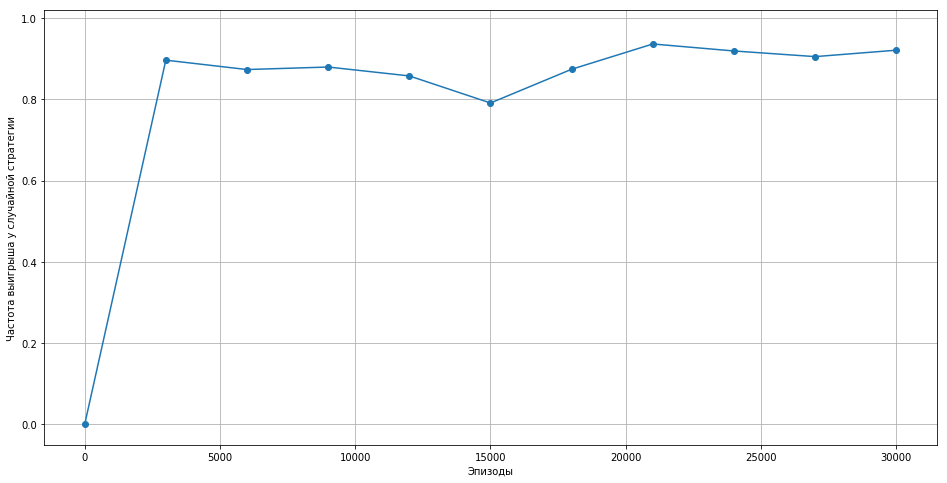

CPU times: user 1h 58min 39s, sys: 4min 8s, total: 2h 2min 48s
Wall time: 19min 56s


In [211]:
%%time
DQN = TTTDQN(gamma=0.7, batch_size=128, N_ROWS=5, N_COLS=5, N_WIN=4)
n_iters = 30000
delta_inf = 3000
G = [0]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    DQN.run(delta_inf, do_learning=True, greedy=False)
    gain = DQN.run(10000, do_learning=False, greedy=True)
    G.append(gain)
    episode.append(i*delta_inf)
    
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Частота выигрыша у случайной стратегии')
plt.grid()
plt.ylim([-0.05,1.02])
plt.show()

### Double DQN

In [8]:
class TTTDoubleDQN():
    def __init__(self, gamma=0.95, N_ROWS=3, N_COLS=3, N_WIN=3, batch_size=64):
        self.env = TicTacToe(N_ROWS,N_COLS,N_WIN)
        self.modelA = DQNetwork(N_ROWS,N_COLS)
        self.modelB = DQNetwork(N_ROWS,N_COLS)
        self.memory = ReplayMemory(30*batch_size)
        self.optimizerA = optim.Adam(self.modelA.parameters(), 0.001)
        self.optimizerB = optim.Adam(self.modelB.parameters(), 0.001)
        self.steps_done = 0
        self.N_ROWS = N_ROWS
        self.N_COLS = N_COLS
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.num_step = 0
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        
        self.update_a = True

    def select_greedy_action(self, state):
        if self.update_a:
            return self.modelA(state).data.max(1)[1].view(1, 1)
        else:
            return self.modelA(state).data.max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            action = random_choice(self.env.getEmptySpaces())
            action = self.env.int_from_action(action)
            return torch.tensor([[action]], dtype=torch.int64)

    
    
    def run_episode(self, do_learning=True, greedy=False):
        
        self.env.reset()
        state = self.env.board.reshape(1, self.N_ROWS, self.N_COLS)
        done = False
        
        while not done:
            
            self.update_a = np.random.uniform() > 0.5
            if self.env.curTurn == 1:
                state_tensor = torch.tensor([state], dtype=torch.float32)
                with torch.no_grad():
                    if greedy:
                        action = self.select_greedy_action(state_tensor)
                    else:
                        action = self.select_action(state_tensor)
                
                _, reward, done, _ = self.env.step(self.env.action_from_int(action.numpy()[0][0]))
                next_state = self.env.board.reshape(1, self.N_ROWS, self.N_COLS)
                next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

                
                if do_learning:
                    transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                    self.memory.store(transition)
                    self.learn()

            else:
                action = random_choice(self.env.getEmptySpaces())
                _, reward, done, _ = self.env.step(action)
                next_state = self.env.board.reshape(1, self.N_ROWS, self.N_COLS)
                

            state = next_state
            
        return reward


    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
            
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        if self.update_a:
            Q = self.modelA(batch_state).gather(1, batch_action).reshape([self.batch_size])
            
            ind = self.modelA(batch_next_state).detach().max(1)[1].reshape(-1,1)
            Qmax = self.modelB(batch_next_state).detach().gather(1, ind).reshape(-1)
            Qnext = batch_reward + (self.gamma * Qmax)
        else:
            Q = self.modelB(batch_state).gather(1, batch_action).reshape([self.batch_size])
            
            ind = self.modelB(batch_next_state).detach().max(1)[1].reshape(-1,1)
            Qmax = self.modelA(batch_next_state).detach().gather(1, ind).reshape(-1)
            Qnext = batch_reward + (self.gamma * Qmax)

        loss = F.smooth_l1_loss(Q, Qnext)
        if self.update_a:
            self.optimizerA.zero_grad()
            loss.backward()
            self.optimizerA.step()
        else:
            self.optimizerB.zero_grad()
            loss.backward()
            self.optimizerB.step()
        
        
    def run(self,n_iters=10000, do_learning=True, greedy=False):
        avg_V = 0
        for i in range(1, n_iters+1):
            G = self.run_episode(do_learning=do_learning, greedy=greedy)
            avg_V += (G - avg_V) / i
            
        return avg_V

## Для доски 3x3

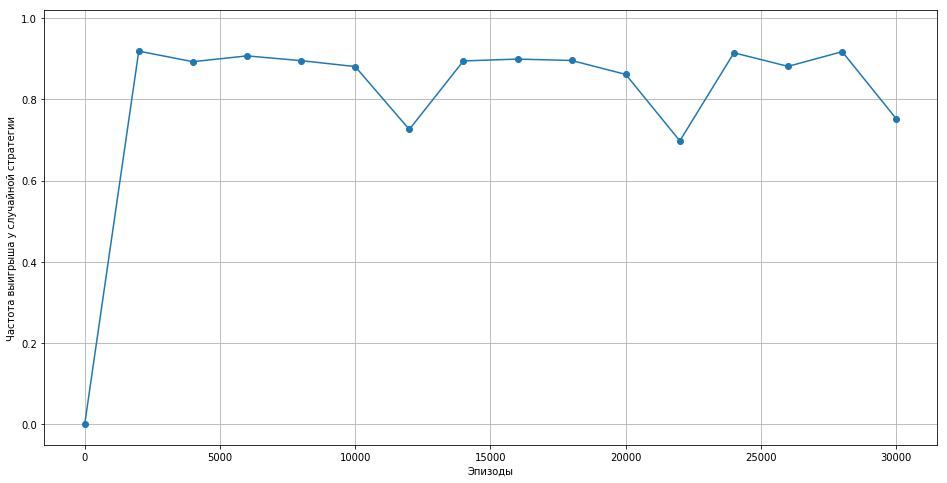

CPU times: user 36min 51s, sys: 32.6 s, total: 37min 24s
Wall time: 7min 24s


In [10]:
%%time
DoubleDQN = TTTDoubleDQN(gamma=0.6, batch_size=128)
n_iters = 30000
delta_inf = 2000
G = [0]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    DoubleDQN.run(delta_inf, do_learning=True, greedy=False)
    gain = DoubleDQN.run(10000, do_learning=False, greedy=True)
    G.append(gain)
    episode.append(i*delta_inf)
    
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Частота выигрыша у случайной стратегии')
plt.grid()
plt.ylim([-0.05,1.02])
plt.show()

## Для доски 4x4

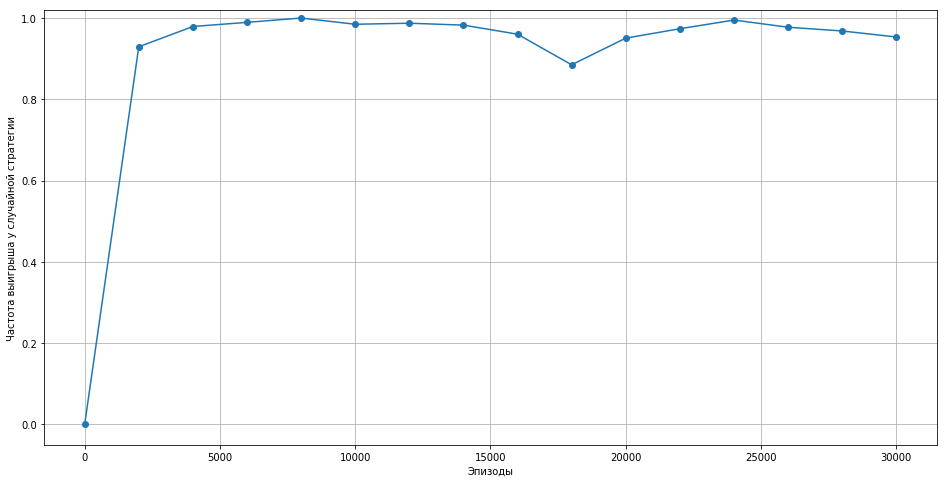

CPU times: user 52min 30s, sys: 54.1 s, total: 53min 24s
Wall time: 10min 5s


In [11]:
%%time
DoubleDQN = TTTDoubleDQN(gamma=0.7, batch_size=128, N_COLS=4,N_ROWS=4)
n_iters = 30000
delta_inf = 2000
G = [0]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    DoubleDQN.run(delta_inf, do_learning=True, greedy=False)
    gain = DoubleDQN.run(10000, do_learning=False, greedy=True)
    G.append(gain)
    episode.append(i*delta_inf)
    
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Частота выигрыша у случайной стратегии')
plt.grid()
plt.ylim([-0.05,1.02])
plt.show()

## Для доски 5x5

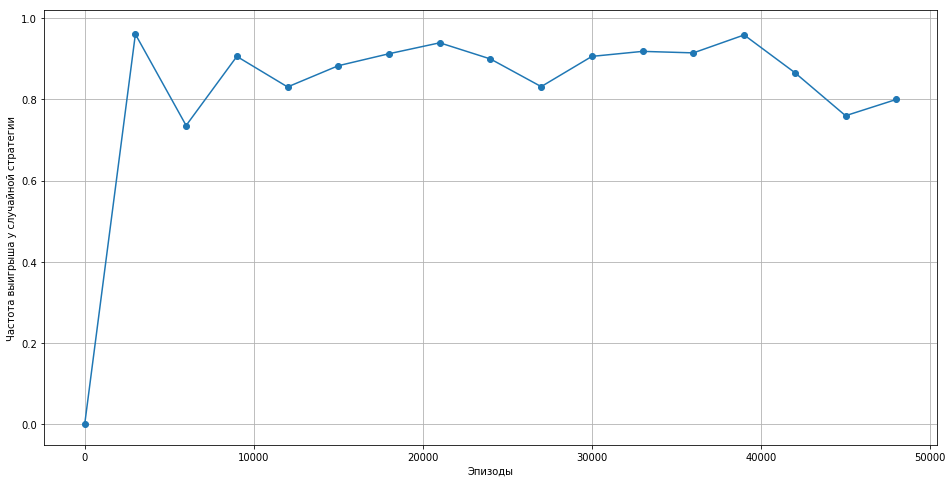

CPU times: user 3h 18min 21s, sys: 2min 30s, total: 3h 20min 51s
Wall time: 31min 7s


In [12]:
%%time
DoubleDQN = TTTDoubleDQN(gamma=0.7, batch_size=128, N_COLS=5,N_ROWS=5, N_WIN=4)
n_iters = 50000
delta_inf = 3000
G = [0]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    DoubleDQN.run(delta_inf, do_learning=True, greedy=False)
    gain = DoubleDQN.run(10000, do_learning=False, greedy=True)
    G.append(gain)
    episode.append(i*delta_inf)
    
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Частота выигрыша у случайной стратегии')
plt.grid()
plt.ylim([-0.05,1.02])
plt.show()

# Часть третья: расширим и углубим поиск

Крестики-нолики - это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS - заодно фактически получится и упражнение на многоруких бандитов.

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнениинескольких паттернов или на Q-функции, которая у вас получилась в первом
пункте).

6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного
размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [488]:
class TTTMCTS():

    def __init__(self, env, board, parent_node=None):
        
        self.env = TicTacToe(env.n_rows, env.n_cols, env.n_win)
        self.env.board = board.copy()
        self.env.isTerminal()
        
        self.parent_node = parent_node
        self.empty_spaces = list(self.env.getEmptySpaces())
        self.child_nodes = []
        
        self.w = 0
        self.n = 0

    def rollout(self):
        
        env = TicTacToe(self.env.n_rows, self.env.n_cols, self.env.n_win)
        env.board = self.env.board.copy()
        env.curTurn = self.env.curTurn
        
        reward = env.isTerminal()
        done = env.gameOver
        empty_spaces = list(np.random.permutation(env.getEmptySpaces()))
        
        while not done:
            action = empty_spaces.pop()
            _, reward, done, _ = env.step(action)
        return reward * self.env.curTurn
    
    def enlarge(self):
        
        action = self.empty_spaces.pop(0)
        next_board = self.env.board.copy()
        next_board[action[0], action[1]] = self.env.curTurn
        
        child_node = TTTMCTS(self.env, next_board, parent_node=self)
        child_node.env.curTurn = -self.env.curTurn
        self.child_nodes.append(child_node)
        
        return child_node
    
    def get_best_child_node(self, c=1):
        ucb = lambda node: -node.w / node.n + c * np.sqrt((np.log(self.n) / node.n))
        priority = list(map(ucb, self.child_nodes)) 
        return np.argmax(priority)
    
    def backward(self, reward):
        self.n += 1
        self.w += reward
        
        if self.parent_node:
            self.parent_node.backward(-reward)

In [502]:
class MCTSTrain():
    def __init__(self, env, n_round_search):
        self.env = env
        self.n_round_search = n_round_search
        
    def next_action(self, board):
        root = TTTMCTS(self.env, board)
        
        for _ in range(self.n_round_search):            
            node = root
            
            while not node.env.gameOver:
                if len(node.empty_spaces) > 0:
                    node = node.enlarge()
                else:
                    node = node.child_nodes[node.get_best_child_node()]
            reward = node.rollout()
            node.backward(reward)
            
        return root.get_best_child_node(c=0)

In [503]:
def run_episode(env, pi):
    
    done = False
    env.reset()
    
    while not done:
        state, empty_spaces = env.board, env.getEmptySpaces()
        if env.curTurn == 1:
            actions = empty_spaces[pi.next_action(state)]
        else:
            actions = random_choice(empty_spaces)
            
        _, reward, done, _ = env.step(actions)
    return reward

def run(env, pi, n_iters=1000):
    wins = 0
    for _ in range(n_iters):
        reward = run_episode(env, pi)
        if reward == 1:
            wins += 1
    return wins / n_iters

## Для доски 3x3

In [505]:
env = TicTacToe(3,3,3)
mcts = MCTSTrain(env, n_round_search=100)
print("частота выигрыша у случайной стратегии", run(env, mcts, n_iters=100))

частота выигрыша у случайной стратегии 0.95


## Для доски 4x4

In [509]:
env = TicTacToe(4,4,4)
mcts = MCTSTrain(env, n_round_search=300)
print("частота выигрыша у случайной стратегии", run(env, mcts, n_iters=100))

частота выигрыша у случайной стратегии 0.96


## Для доски 5x5

In [511]:
env = TicTacToe(5,5,5)
mcts = MCTSTrain(env, n_round_search=300)
print("частота выигрыша у случайной стратегии", run(env, mcts, n_iters=200))

частота выигрыша у случайной стратегии 0.905
